In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import sys
import matplotlib.pyplot as plt

print(f'PID number is {os.getpid()}')

PID number is 21488


# Load clustered adata

In [2]:
# read the clustered scRNA sequencing h5ad file from GSE113901
adata = sc.read_h5ad(r"sc_clustered.h5ad")

In [3]:
mouse_ids = []
for i, row in adata.obs.iterrows():
    mouse_ids.append(i[:3])
adata.obs['mouse_id'] = mouse_ids

C:\Users\cosmosyw\anaconda3\envs\merlin_postanalysis\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


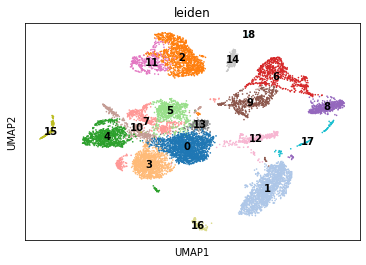

CPU times: total: 7.66 s
Wall time: 7.51 s


In [4]:
%%time
# Clustering
sc.tl.leiden(adata, resolution=0.5)
# Embed with UMAP
sc.tl.umap(adata)
# Plot the UMAP
sc.pl.umap(adata, color='leiden', legend_loc='on data', palette='tab20')

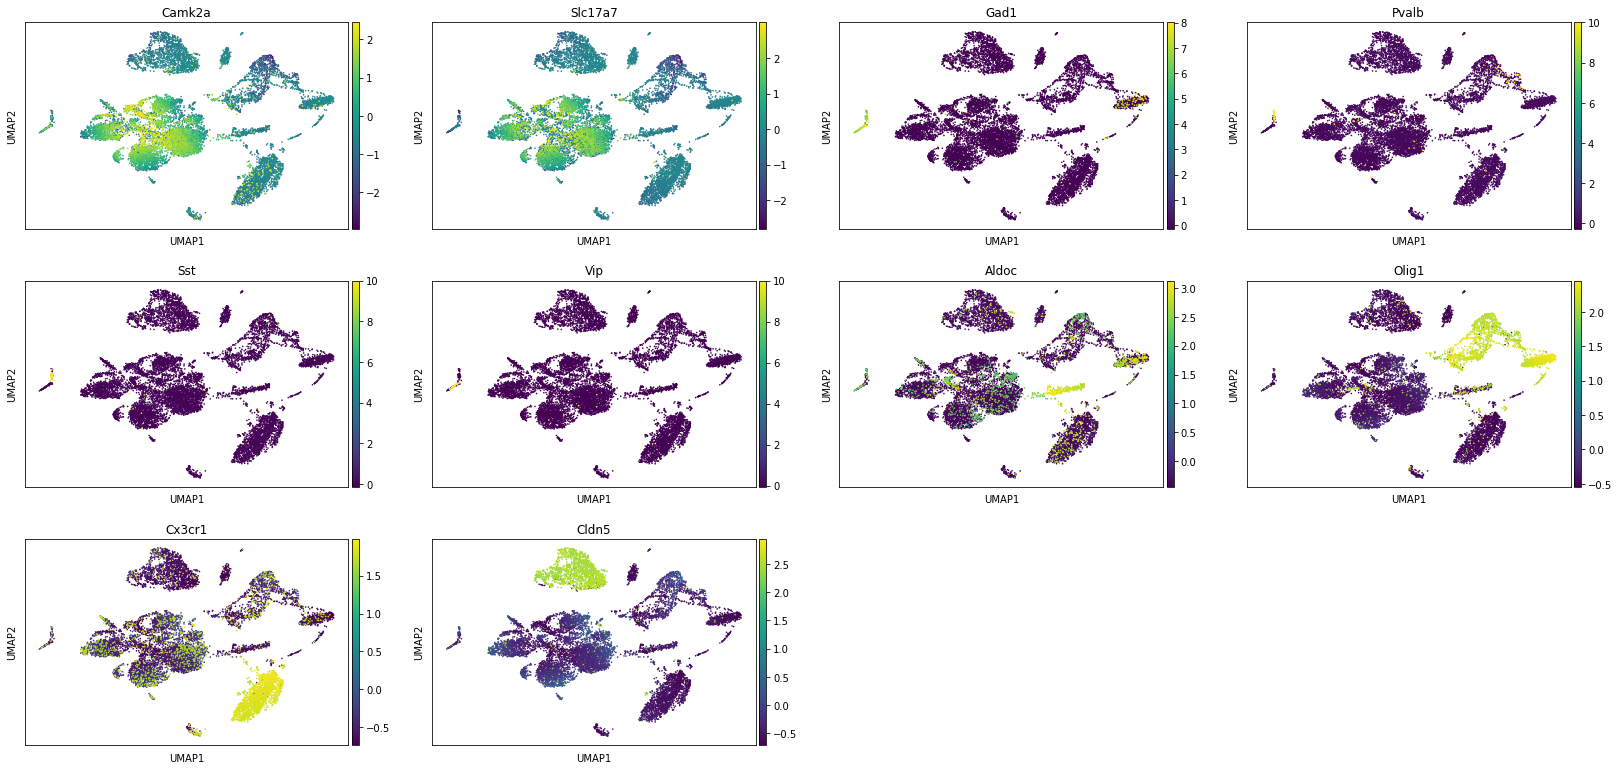

In [5]:
marker_genes = ['Camk2a', 'Slc17a7', 'Gad1', 'Pvalb', 'Sst', 'Vip', 'Aldoc', 'Olig1', 'Cx3cr1', 'Cldn5']
marker_genes = [g for g in marker_genes if (g in adata.var.index)]
sc.pl.umap(adata, color=marker_genes)

In [20]:
manual_cluster = {'Gluta':['0','3','4','5','7','10','13'],
                  'GABA':['15'], 'Astro':['12'],
                  'Oligo':['6','8','9'], 'Micro':['1'], 'Endo':['2','11']}
cluster_to_majortypes = {}
for key in manual_cluster.keys():
    for cluster_num in manual_cluster[key]:
        cluster_to_majortypes[cluster_num] = key
for cluster_num in np.unique(adata.obs.leiden.values):
    if cluster_num not in cluster_to_majortypes.keys():
        cluster_to_majortypes[cluster_num]='other'

In [21]:
adata.obs['majorType'] = adata.obs.leiden.apply(lambda x: cluster_to_majortypes[x])
adata.obs.head()

,genotype,n_genes_by_counts,total_counts,leiden,mouse_id,majorType
WT1_bcGGGN,WT,2630,9360.0,6,WT1,Oligo
WT1_bcEIMI,WT,3310,8381.0,4,WT1,Gluta
WT1_bcGYWF,WT,2868,6211.0,3,WT1,Gluta
WT1_bcAVBN,WT,2591,5549.0,0,WT1,Gluta
WT1_bcFOTP,WT,2135,4374.0,6,WT1,Oligo


In [22]:
adata.obs['counts_per_gene'] = adata.obs['total_counts']/adata.obs['n_genes_by_counts']

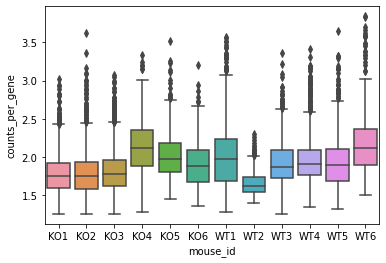

In [23]:
plt.figure()
sns.boxplot(data=adata.obs, x='mouse_id', y='counts_per_gene')
plt.show()

In [24]:
######### load gene info
df_gene_info = pd.read_csv('gene_info.csv')
gene_to_chr = {gene:chrom for (gene, chrom) in zip(df_gene_info['gene'].values, df_gene_info['chr'].values)}

adata.var['gene_name'] = adata.var.index
adata.var['chr'] = adata.var['gene_name'].apply(lambda x: gene_to_chr[x] if x in gene_to_chr.keys() else 'NA')
adata.var.drop(columns='gene_name', axis=1, inplace=True)
adata.var

,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,mean,std,chr
gene,,,,,,,
0610006L08Rik,0,0.000000,100.000000,0.0,0.000000e+00,1.000000,chr7
0610007P14Rik,1611,0.186335,86.031388,2149.0,3.152591e-10,2.141989,chr12
0610009B22Rik,716,0.073095,93.791728,843.0,-2.274000e-10,1.496669,chr11
0610009E02Rik,52,0.004769,99.549120,55.0,9.825603e-11,0.413989,chr2
0610009L18Rik,187,0.018209,98.378566,210.0,-5.006676e-11,0.793892,chr11
...,...,...,...,...,...,...,...
mt-Nd3,7438,1.571577,35.506807,18125.0,-3.661940e-10,3.099748,chrM
mt-Nd4,11504,20.430244,0.251452,235622.0,-1.374849e-12,0.420442,chrM
mt-Nd4l,2916,0.359490,74.716032,4146.0,4.444637e-10,2.798695,chrM


# Load raw h5ad

In [27]:
# load the adata with raw counts for further DEG analysis
adata_raw = sc.read_h5ad('sc_raw_MeCP2.h5ad')
adata_raw.obs = adata_raw.obs.merge(adata.obs, left_index=True, right_index=True)
adata_raw.var = adata_raw.var.merge(adata.var, left_index=True, right_index=True)

In [30]:
# output adata
adata_raw.write_h5ad(r'resources/GSE113901_sc_raw_labeled_clustered_with_chr_info.h5ad')

In [31]:
adata_raw.obs.head()

,genotype,n_genes_by_counts,total_counts,leiden,mouse_id,majorType,counts_per_gene
WT1_bcGGGN,WT,2630,9360.0,6,WT1,Oligo,3.558935
WT1_bcEIMI,WT,3310,8381.0,4,WT1,Gluta,2.532024
WT1_bcGYWF,WT,2868,6211.0,3,WT1,Gluta,2.165621
WT1_bcAVBN,WT,2591,5549.0,0,WT1,Gluta,2.141644
WT1_bcFOTP,WT,2135,4374.0,6,WT1,Oligo,2.048712
